# Нелинейная механика разрушения

## Введение

In [336]:
# модуль символьных вычислений
import sympy as sp

# массивы
import numpy as np

# Для численного интегрирования дифференциальных уранвений
from scipy.integrate import solve_ivp

# Для численного решения нелинейных уравнений   f(x) = 0
from scipy.optimize import root

# Для построения графиков
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab

# Настройка стиля графиков
pylab.rcParams.update({'legend.fontsize': 14, 'figure.figsize': (12, 8), 
                       'axes.labelsize': 14,  'axes.titlesize':14, 'xtick.labelsize':14,
                       'ytick.labelsize':14})

In [337]:
# функция f
f = sp.Function('f')

t, l, n = sp.symbols('t, l, n')
df, d2f, d3f = sp.symbols('df, d2f, d3f')

## Напряжения

In [358]:
sigma_rr = (l+1)*f(t) + sp.diff(f(t),t,2)
sigma_tt = (l+1)*l*f(t) 
sigma_rt =-l*sp.diff(f(t),t)

## Плоское напряженное состояние

### Интенсивность напряжений

In [359]:
se_pn = (sigma_rr**2 + sigma_tt**2 - sigma_rr*sigma_tt + 3*sigma_rt**2)**(1/2)

### Деформации

In [360]:
epsilon_rr = se_pn**(n-1)*(sigma_rr-(sigma_rr+sigma_tt)/3)
epsilon_tt = se_pn**(n-1)*(sigma_tt-(sigma_rr+sigma_tt)/3)
epsilon_rt = se_pn**(n-1)*sigma_rt

### Замены (значения) для l и n

In [341]:
params = [ (l, (2*n+1)/(n+1)), (n, 2) ]

### Построение диф. уравнений

In [362]:
eq  = 2*((l-1)*n+1)*sp.diff(epsilon_rt,t) - sp.diff(epsilon_rr,t,2) + \
      (l-1)*n*epsilon_rr - ((l-1)*n+1)*(l-1)*n*epsilon_tt

## Разрешаем относительно старшей производной (4 порядка)
eqs = sp.solve( eq.subs(params), sp.diff(f(t),t,4)) 

## Функция вычисления значения 4-ой производной для заданных значений  f, f', f'', f'''
fdfd2fd3f = [f(t), sp.diff(f(t),t), sp.diff(f(t),t,2), sp.diff(f(t),t,3)]

eqn  = sp.lambdify(fdfd2fd3f, eqs)

Функции для вычисления значений напряжений по значениям f, f', f'', f'''

In [363]:
sigma_rr_num = sp.lambdify( fdfd2fd3f, sigma_rr.subs(params))
sigma_tt_num = sp.lambdify( fdfd2fd3f, sigma_tt.subs(params))
sigma_rt_num = sp.lambdify( fdfd2fd3f, sigma_rt.subs(params))

Функция правых частей системы дифференциальных уравнений

In [364]:
eq_ode = lambda t, q : np.append(q[1:4],eqn(*q))

Функция возвращает решение $f'(\pi)$ для заданных начальный условий $f(0) = c_1$ и $f''(0) = c_2$ (тип I)

Функция необходима для метода пристрелки

In [367]:
def sol_I(c1, c2):
    sol = solve_ivp(eq_ode, [0, np.pi], [c1,0,c2,0], rtol = 1e-8, method="LSODA")
    return sol.y[1,-1]

Пристрелка. Определение значения $c_2$ решением уравнения $f'(\pi) = 0$

In [369]:
# Находим c2
c2_I = root(lambda c2: sol_I(1.0,c2), 0).x[0]
print('Найдено c2 = {:6.3f}'.format(c2_I))

# Решаем ДУ для найденного значния c2 
sol = solve_ivp(eq_ode, [0, np.pi], [1.0, 0, c2_I, 0], rtol = 1e-8, method="LSODA")

Найдено c2 = -0.139


### Результаты

#### Напряжения

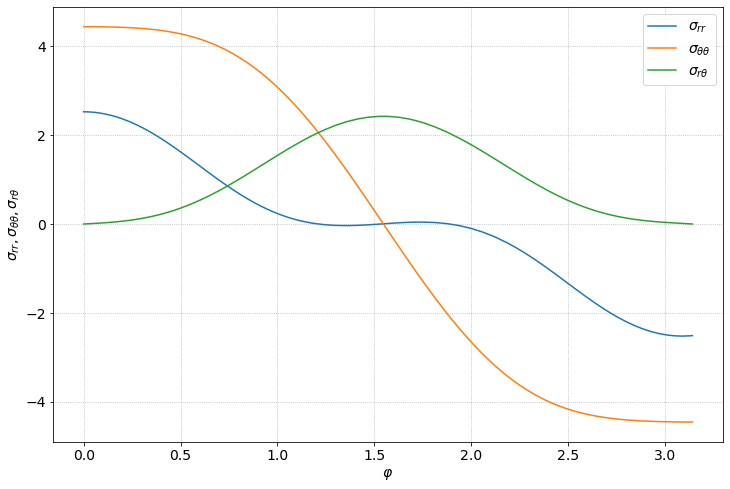

In [370]:
plt.plot(sol.t, [sigma_rr_num(*line) for line in sol.y.transpose()])
plt.plot(sol.t, [sigma_tt_num(*line) for line in sol.y.transpose()])
plt.plot(sol.t, [sigma_rt_num(*line) for line in sol.y.transpose()])

plt.xlabel('$\\varphi$');
plt.ylabel('$\sigma_{rr}, \sigma_{\\theta\\theta}, \sigma_{r\\theta}$')
plt.legend(['$\sigma_{rr}$','$\sigma_{\\theta\\theta}$','$\sigma_{r\\theta}$']);
plt.grid(linestyle=':');


#### Функции f, f', f'', f'''

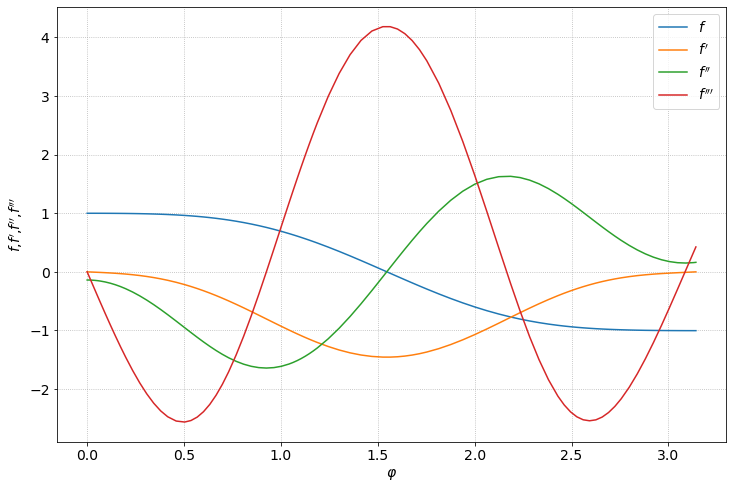

In [371]:
plt.plot(sol.t, sol.y[0])
plt.plot(sol.t, sol.y[1])
plt.plot(sol.t, sol.y[2])
plt.plot(sol.t, sol.y[3])
plt.xlabel('$\\varphi$'); plt.ylabel('$f$,$f\'$,$f\'\'$,$f\'\'\'$');
plt.grid(linestyle=':');
plt.legend(['$f$','$f\'$','$f\'\'$','$f\'\'\'$']);

## Плоское деформированное состояние

### Интенсивность напряжений

In [372]:
se_pd = (3*(sigma_rr-sigma_tt)**2/4 + 3*sigma_rt**2)**(1/2)

### Деформации

In [373]:
epsilon_rr = se_pd**(n-1)*(sigma_rr-(sigma_rr+sigma_tt)/3)
epsilon_tt = se_pd**(n-1)*(sigma_tt-(sigma_rr+sigma_tt)/3)
epsilon_rt = se_pd**(n-1)*sigma_rt

### Замены для l и n

In [374]:
params = [ (l, (2*n+1)/(n+1)), (n, 2) ]

### Построение диф. уравнений

In [375]:
eq  = 2*((l-1)*n+1)*sp.diff(epsilon_rt,t) - sp.diff(epsilon_rr,t,2) + \
      (l-1)*n*epsilon_rr - ((l-1)*n+1)*(l-1)*n*epsilon_tt

eqs = sp.solve( eq.subs(params), sp.diff(f(t),t,4)) 

eqn  = sp.lambdify( [f(t), sp.diff(f(t),t), sp.diff(f(t),t,2), sp.diff(f(t),t,3)], eqs)

Функции для вычисления значений напряжений по значениям f, f', f'', f'''

In [376]:
sigma_rr_num = sp.lambdify( [f(t), sp.diff(f(t),t), sp.diff(f(t),t,2), sp.diff(f(t),t,3)], sigma_rr.subs(params))
sigma_tt_num = sp.lambdify( [f(t), sp.diff(f(t),t), sp.diff(f(t),t,2), sp.diff(f(t),t,3)], sigma_tt.subs(params))
sigma_rt_num = sp.lambdify( [f(t), sp.diff(f(t),t), sp.diff(f(t),t,2), sp.diff(f(t),t,3)], sigma_rt.subs(params))

Функция правых частей системы дифференциальных уравнений

In [377]:

eq_ode = lambda t, q : np.append(q[1:4],eqn(*q))

Функция возвращает решение $f'(\pi)$ для заданных начальный условий $f(0) = c_1$ и $f''(0) = c_2$ (тип I)

In [378]:
def sol_I(c1, c2):
    sol = solve_ivp(eq_ode, [0, np.pi], [c1,0,c2,0], rtol = 1e-8, method="LSODA")
    return sol.y[1,-1]

Определение значения $c_2$ решением уравнения $f'(\pi) = 0$

In [379]:
c2_I = root(lambda c2: sol_I(1.0,c2), 0).x[0]
sol = solve_ivp(eq_ode, [0, np.pi], [1.0, 0, c2_I, 0], rtol = 1e-8, method="LSODA")

### Результаты

#### Напряжения

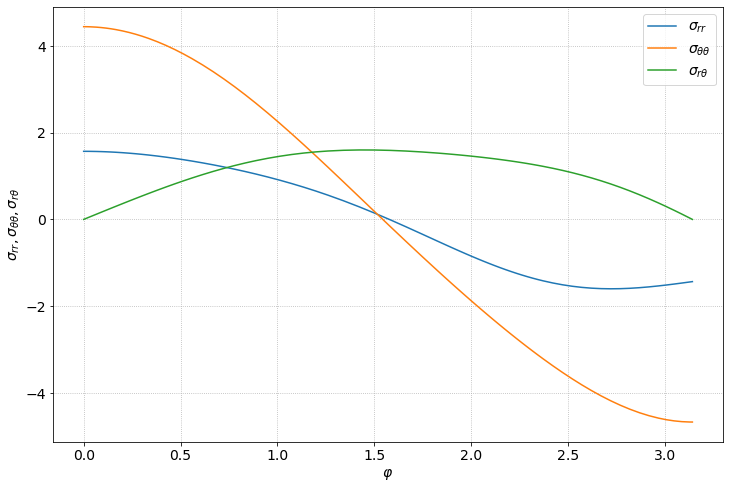

In [380]:
plt.plot(sol.t, [sigma_rr_num(*line) for line in sol.y.transpose()])
plt.plot(sol.t, [sigma_tt_num(*line) for line in sol.y.transpose()])
plt.plot(sol.t, [sigma_rt_num(*line) for line in sol.y.transpose()])

plt.xlabel('$\\varphi$');
plt.ylabel('$\sigma_{rr}, \sigma_{\\theta\\theta}, \sigma_{r\\theta}$')
plt.legend(['$\sigma_{rr}$','$\sigma_{\\theta\\theta}$','$\sigma_{r\\theta}$']);
plt.grid(linestyle=':');


#### Функции f, f', f'', f'''

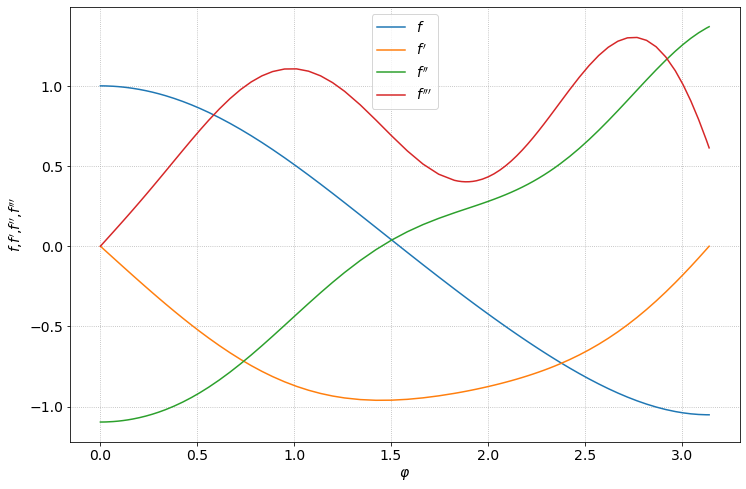

In [381]:
plt.plot(sol.t, sol.y[0])
plt.plot(sol.t, sol.y[1])
plt.plot(sol.t, sol.y[2])
plt.plot(sol.t, sol.y[3])
plt.xlabel('$\\varphi$'); plt.ylabel('$f$,$f\'$,$f\'\'$,$f\'\'\'$');
plt.grid(linestyle=':');
plt.legend(['$f$','$f\'$','$f\'\'$','$f\'\'\'$']);